# classification with xgboost
model v5
- preliminary model (no hyperparameter tuning)
- data with all 1352 important features based on pca and threshold
- imbalanced classification dealt with using over- and under-sampling techniques

data
- using 3 classification labels instead of 2

Source: [10 Techniques To Deal With Imbalanced Classes in Machine Learning](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/)

In [1]:
# ignore warnings
import warnings
warnings.filterwarnings("ignore")

# data
import pandas as pd
import ast
from numpy import mean

# visualization
import matplotlib.pyplot as plt

# chosen models
from xgboost import XGBClassifier

# feature engineering
from xgboost import plot_importance

# imbalanced data
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, NearMiss
from imblearn.over_sampling import RandomOverSampler, SMOTE


# model training selection
from sklearn.model_selection import train_test_split

## model evaluation metrics
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import log_loss
from sklearn.metrics import matthews_corrcoef
from sklearn.metrics import cohen_kappa_score

In [2]:
df = pd.read_csv('../data/combined_feng3.csv', index_col=0)
df.shape

(3000, 7353)

In [3]:
df.head(3)

,Number of Founders,Number of Funding Rounds,Trend Score (7 Days),Trend Score (30 Days),Trend Score (90 Days),Early Stage Venture,M&A,Seed,Made Acquisitions,Made Acquisitions; Was Acquired,...,last_funding_amount,cvr,last_funding_amount_usd,last_equity_funding_amount,last_equity_funding_amount_usd,total_equity_funding_amount,total_equity_funding_amount_usd,total_funding_amount,total_funding_amount_usd,female_led
Organization Name,,,,,,,,,,,,,,,,,,,,,
CMC,1,1,-0.4,-0.8,-1.2,1.0,0.0,0.0,0.0,0.0,...,10000000000,0.16,1.600000e+09,10000000000,1.600000e+09,10000000000,1.600000e+09,10000000000,1.600000e+09,2
Ping An Healthcare Management,1,1,-0.1,-0.2,-0.4,1.0,0.0,0.0,0.0,0.0,...,1150000000,1.00,1.150000e+09,1150000000,1.150000e+09,1150000000,1.150000e+09,1150000000,1.150000e+09,2
LeSee,1,1,-0.4,0.0,-0.5,1.0,0.0,0.0,0.0,0.0,...,1080000000,1.00,1.080000e+09,1080000000,1.080000e+09,1080000000,1.080000e+09,1080000000,1.080000e+09,2


### get all top features based on pca

In [4]:
with open('high_var_org_col_index.txt', 'r') as reader:
    high_var_org_col_index = reader.read()

In [5]:
high_var_org_col_index = ast.literal_eval(high_var_org_col_index)

In [6]:
df1352 = df[df.columns[high_var_org_col_index]]

### get data

In [7]:
X = df1352
y = df['female_led']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

## Imbalanced Data

In [9]:
Counter(y)

Counter({2: 2692, 0: 142, 1: 166})

### 1. random under-sampling

In [10]:
rus = RandomUnderSampler(random_state=42, replacement=True)

In [11]:
X_rus, y_rus = rus.fit_resample(X, y)

In [12]:
Counter(y_rus)

Counter({0: 142, 1: 142, 2: 142})

In [13]:
X_rus_train, X_rus_test, y_rus_train, y_rus_test = train_test_split(
    X_rus, y_rus, test_size=0.33, random_state=42)

### 2. random over-sampling

In [14]:
ros = RandomOverSampler(random_state=42)

In [15]:
X_ros, y_ros = ros.fit_resample(X, y)

In [16]:
Counter(y_ros)

Counter({2: 2692, 0: 2692, 1: 2692})

In [17]:
X_ros_train, X_ros_test, y_ros_train, y_ros_test = train_test_split(
    X_ros, y_ros, test_size=0.33, random_state=42)

### 3. tomek links under-sampling

Tomek links are pairs of very close instances but of opposite classes. Removing the instances of the majority class of each pair increases the space between the two classes, facilitating the classification process.

Tomek’s link exists if the two samples are the nearest neighbors of each other

![img](https://miro.medium.com/max/700/1*KxFmI15rxhvKRVl-febp-Q.png)

In [18]:
tl = TomekLinks(sampling_strategy='majority')

In [19]:
X_tl, y_tl = tl.fit_resample(X, y)

In [20]:
Counter(y_tl)

Counter({2: 2530, 0: 142, 1: 166})

In [21]:
X_tl_train, X_tl_test, y_tl_train, y_tl_test = train_test_split(
    X_tl, y_tl, test_size=0.33, random_state=42)

### 4. synthetic minority over-sampling (SMOTE)

This technique generates synthetic data for the minority class.

SMOTE (Synthetic Minority Oversampling Technique) works by randomly picking a point from the minority class and computing the k-nearest neighbors for this point. The synthetic points are added between the chosen point and its neighbors.

![img](https://miro.medium.com/max/734/1*yRumRhn89acByodBz0H7oA.png)

SMOTE algorithm works in 4 simple steps:

1. Choose a minority class as the input vector
2. Find its k nearest neighbors (k_neighbors is specified as an argument in the SMOTE() function)
3. Choose one of these neighbors and place a synthetic point anywhere on the line joining the point under consideration and its chosen neighbor
4. Repeat the steps until data is balanced

In [22]:
smote = SMOTE()

In [23]:
X_smote, y_smote = smote.fit_resample(X, y)

In [24]:
Counter(y_smote)

Counter({2: 2692, 0: 2692, 1: 2692})

In [25]:
X_smote_train, X_smote_test, y_smote_train, y_smote_test = train_test_split(
    X_smote, y_smote, test_size=0.33, random_state=42)

### 5. NearMiss
NearMiss is an under-sampling technique. Instead of resampling the Minority class, using a distance, this will make the majority class equal to the minority class.

In [26]:
nm = NearMiss()

In [27]:
X_nm, y_nm = nm.fit_resample(X, y)

In [28]:
Counter(y_nm)

Counter({0: 142, 1: 142, 2: 142})

In [29]:
X_nm_train, X_nm_test, y_nm_train, y_nm_test = train_test_split(
    X_nm, y_nm, test_size=0.33, random_state=42)

## model evaluation

In [30]:
#metrics3
def metrics(y_true, y_pred):
    accuracy = accuracy_score(y_true, y_pred) #perfect=1
    
    ### adjust average for multiclass
    precision = precision_score(y_true, y_pred, average='micro') #perfect=1
    recall = recall_score(y_true, y_pred, average='micro') #perfect=1
    f1 = f1_score(y_true, y_pred, average='micro') #perfect=1

    # roc_auc = roc_auc_score(y, clf.decision_function(X)) #perfect=1
    # log = log_loss(y_true, y_pred) #perfect=0
    
    mcc = matthews_corrcoef(y_true, y_pred) #perfect=1
    kappa = cohen_kappa_score(y_true, y_pred) #perfect=1
    
#     print(f'accuracy={accuracy},\
#             precision={precision}, recall={recall}, \
#             f1={f1}, mcc={mcc}, kappa={kappa}')
    
#     return [accuracy, precision, recall]
    return [accuracy, precision, recall, f1, mcc, kappa]

In [31]:
def evaluate(model, X_train=X_train, X_test=X_test, y_train=y_train, y_test=y_test):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return metrics(y_test, y_pred)

In [32]:
def important_cols(xgb):
    important_features_dict = xgb.get_booster().get_score(importance_type='weight')
    return list(important_features_dict.keys())

In [33]:
def plot_important_cols(xgb):
    plt.rcParams["figure.figsize"] = (20, 15)
    plot_importance(xgb, max_num_features=50)

## machine learning

In [34]:
# set for multiclass
xgb = XGBClassifier(objective='multi:softmax')

## model evaluation

### 1. random under-sampling

In [35]:
metrics_rus = evaluate(xgb, X_rus_train, X_rus_test, y_rus_train, y_rus_test)
metrics_rus

[16:27:56] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.6453900709219859,
 0.6453900709219859,
 0.6453900709219859,
 0.6453900709219859,
 0.4671009109469647,
 0.4657876790179586]

In [36]:
len(important_cols(xgb))

35

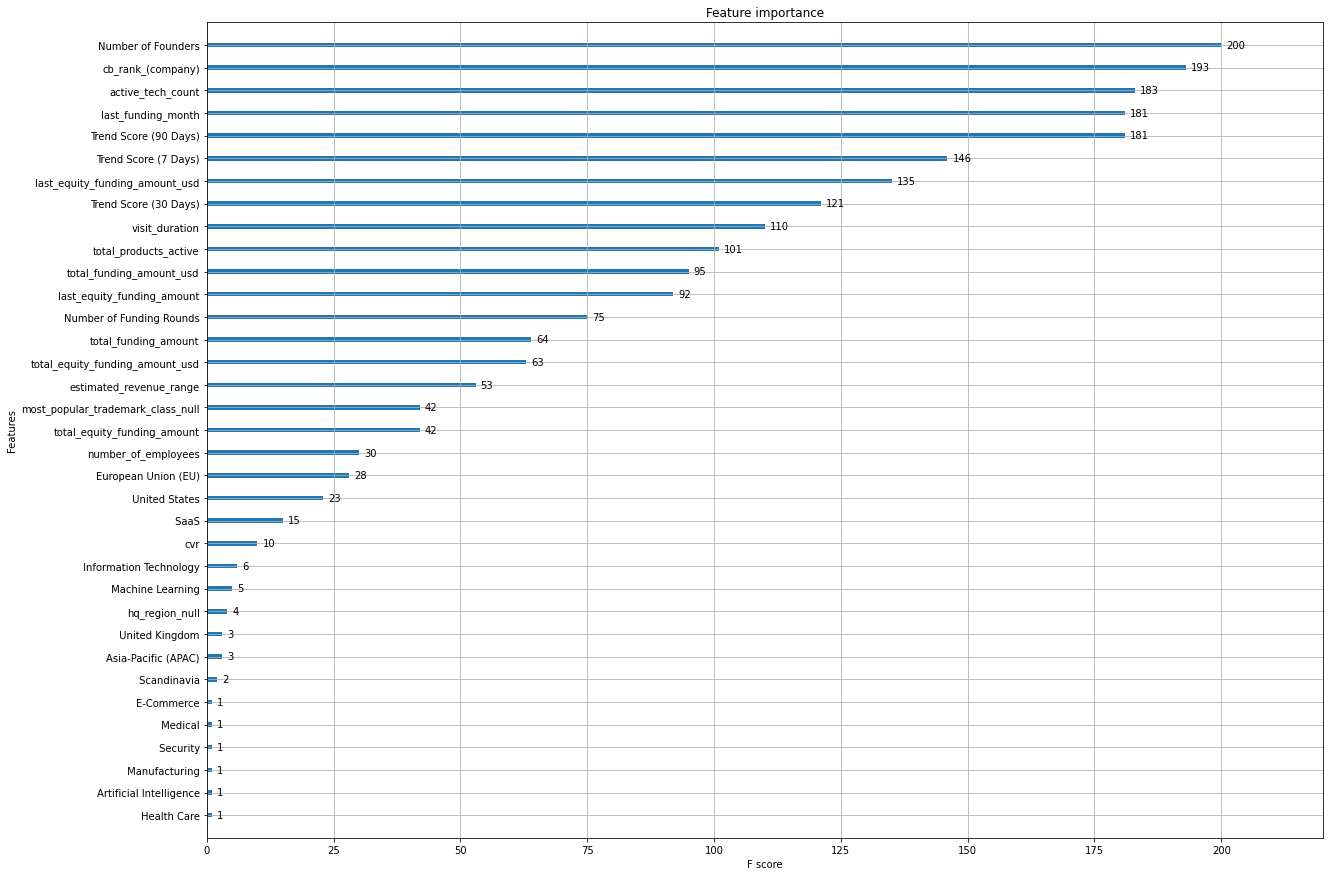

In [37]:
plot_important_cols(xgb)

### 2. random over-sampling

In [38]:
metrics_ros = evaluate(xgb, X_ros_train, X_ros_test, y_ros_train, y_ros_test)
metrics_ros

[16:27:58] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.972993248312078,
 0.972993248312078,
 0.972993248312078,
 0.972993248312078,
 0.9603209570485312,
 0.95949874762866]

In [39]:
len(important_cols(xgb))

141

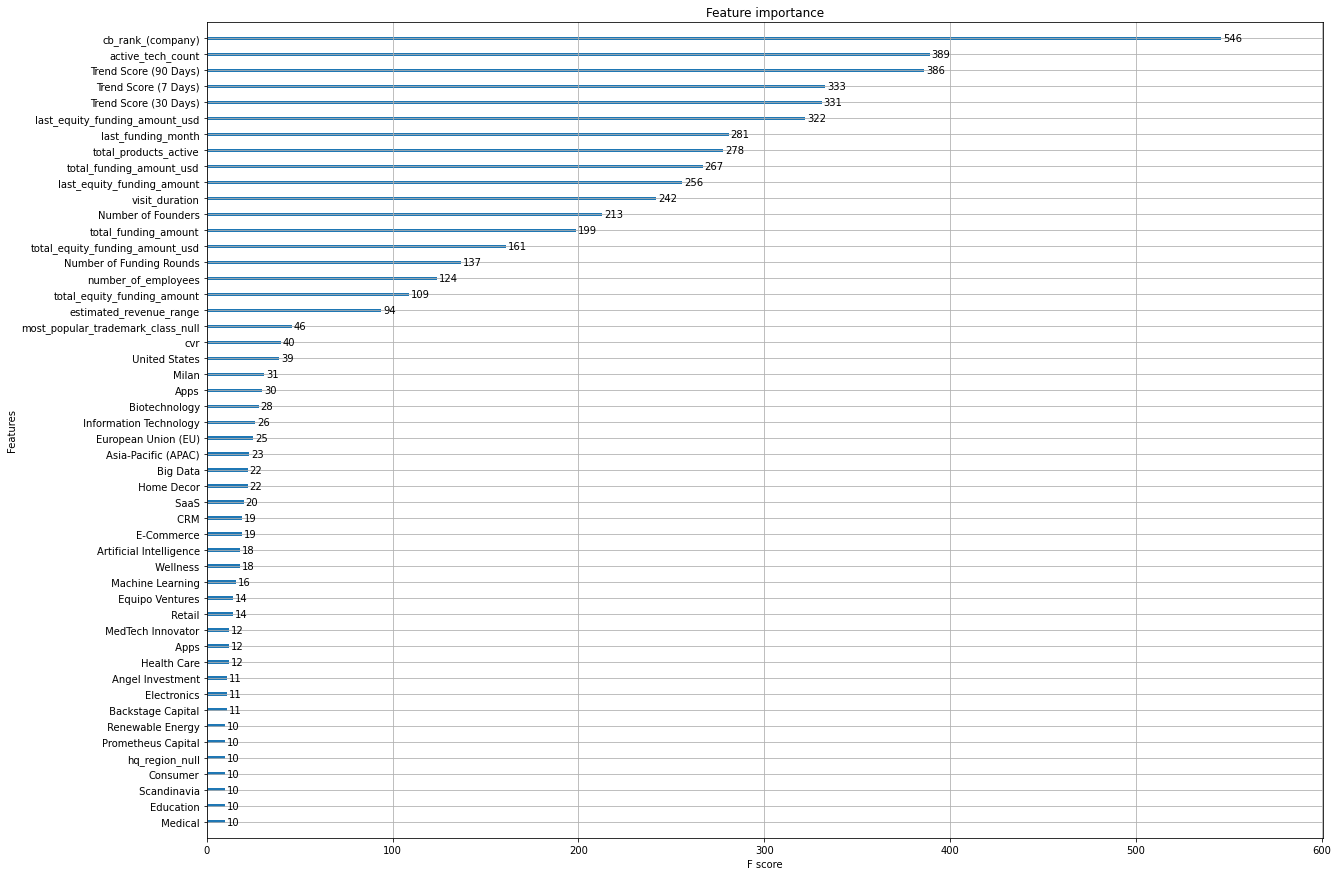

In [40]:
plot_important_cols(xgb)

### 3. tomet links

In [41]:
metrics_tl = evaluate(xgb, X_tl_train, X_tl_test, y_tl_train, y_tl_test)
metrics_tl

[16:28:15] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.8911419423692636,
 0.8911419423692636,
 0.8911419423692636,
 0.8911419423692636,
 0.08366124883115059,
 0.054303298964991975]

In [42]:
len(important_cols(xgb))

63

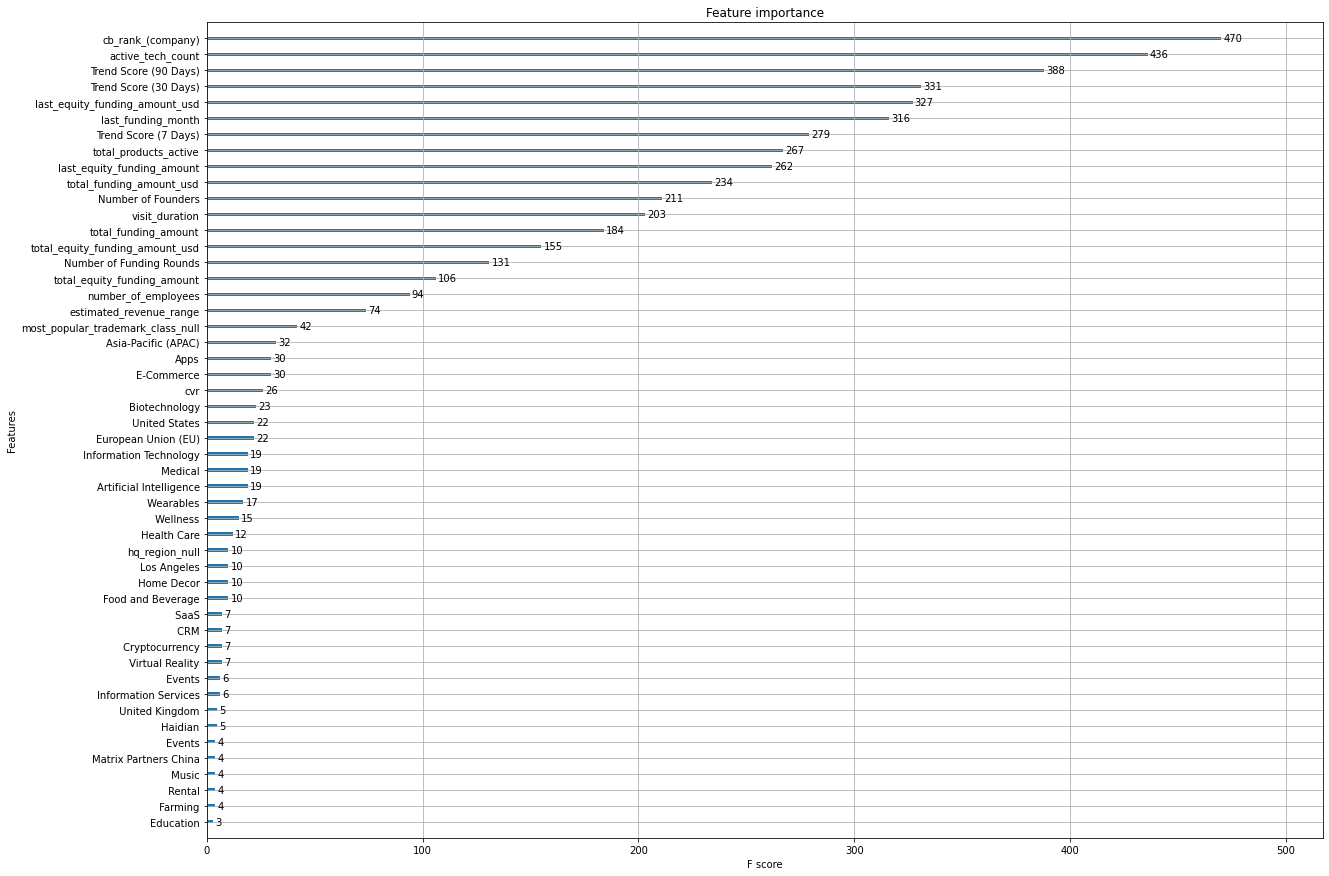

In [43]:
plot_important_cols(xgb)

### 4. smote

In [44]:
metrics_smote = evaluate(xgb, X_smote_train, X_smote_test, y_smote_train, y_smote_test)
metrics_smote

[16:28:22] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.9486121530382595,
 0.9486121530382595,
 0.9486121530382595,
 0.9486121530382595,
 0.9230380236672228,
 0.9229227083010632]

In [45]:
len(important_cols(xgb))

65

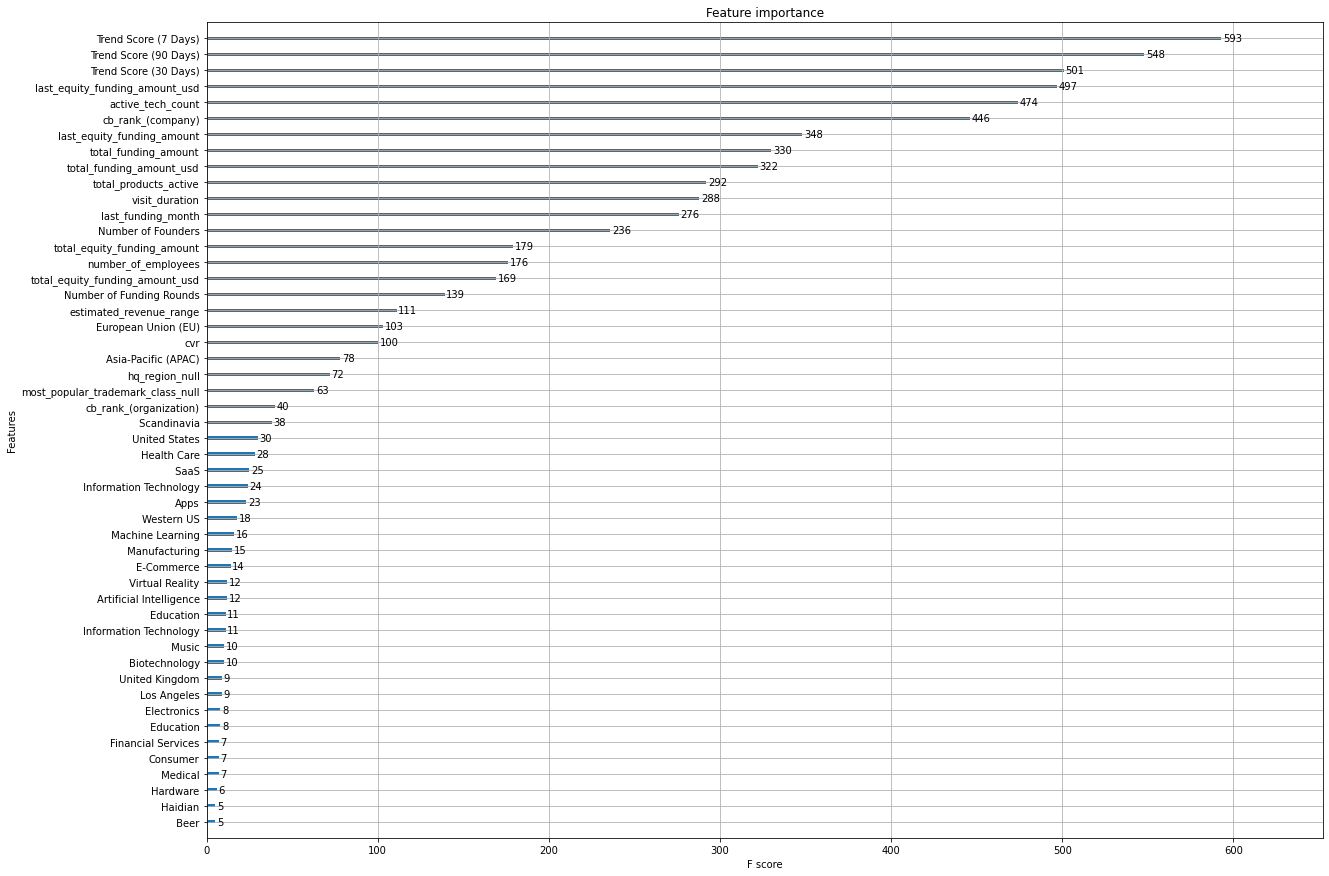

In [46]:
plot_important_cols(xgb)

### 5. nearmiss

In [47]:
metrics_nearmiss = evaluate(xgb, X_nm_train, X_nm_test, y_nm_train, y_nm_test)
metrics_nearmiss

[16:28:40] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'multi:softprob' was changed from 'merror' to 'mlogloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


[0.7730496453900709,
 0.7730496453900709,
 0.7730496453900709,
 0.7730496453900709,
 0.6708861461677774,
 0.6610067618332081]

In [48]:
len(important_cols(xgb))

29

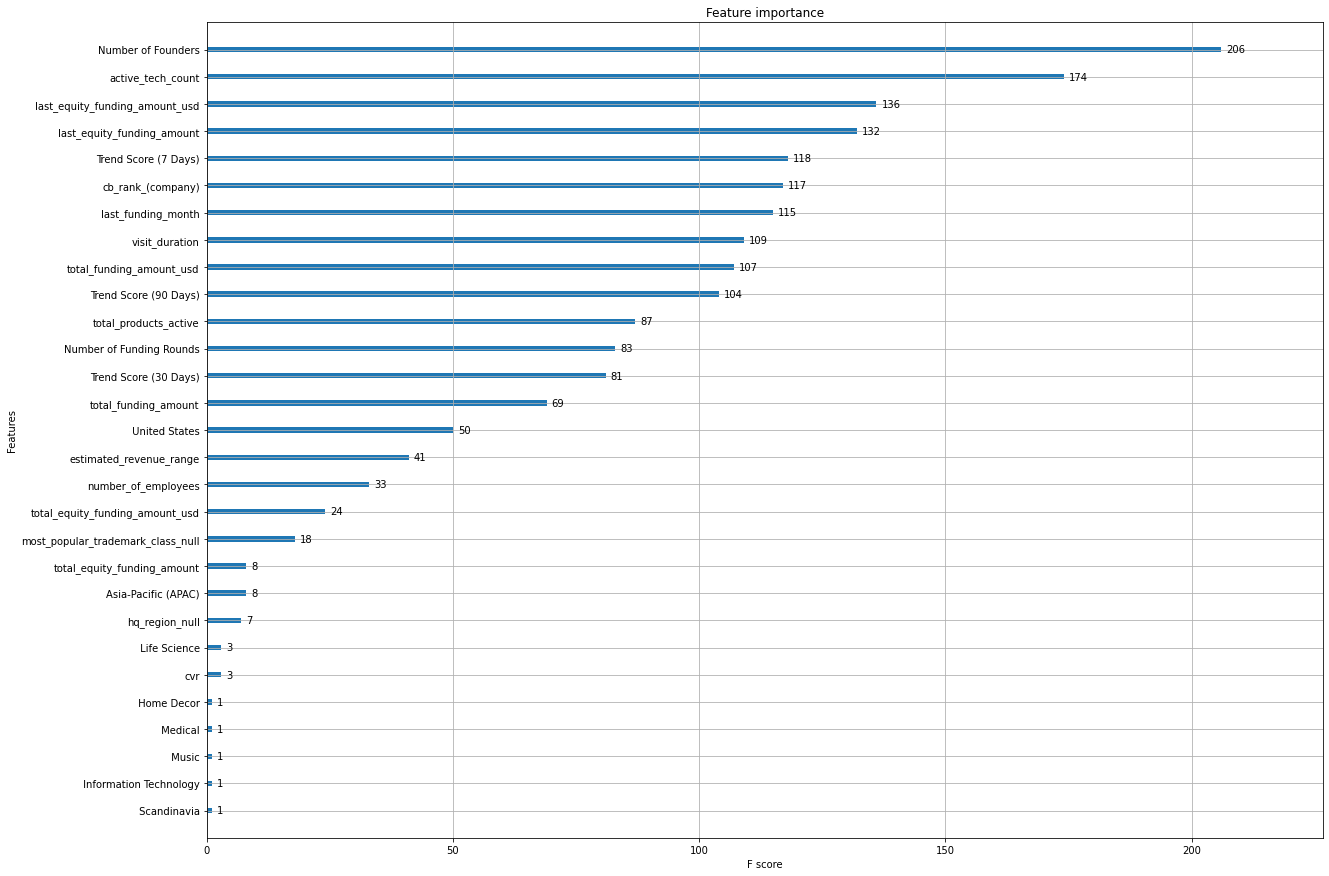

In [49]:
plot_important_cols(xgb)

**[CHANGE]** Result is high in accuracy but precision and recall rate is even lower than before because the classification label is extremely imbalanced: the negative class takes up 95% of the dataset. Dealing with imbalanced class is necessary.

### Feature Selection
Somehow the selected PCA columns also resulted in a very different feature selection in the xgboost model compared to the first time. 
- v1: 92/7532
- v2: 6/100
- v3: 48/1352
- v4:  79/1352
- v5: 
    - random under-sampling: 25/1352
    - random over-sampling: 79/1352
    - tomet links: 39/1352
    - smote: 45/1352
    - nearmiss: 21/1352

v1-v3 does not deal with imbalance of the dataset

### Version Differences

model_version | feature selection | imbalanced class | hyperparameter tuning | cross validation
--------------|-------------------|------------------|-----------------------|-----------------
xgboost_v1 | no | no | no | no
xgboost_v2 | yes, top100 | no | no | no
xgboost_v3 | yes, top all 1352 | no | no | no
xgboost_v4 | yes, top all 1352 | yes (weighted 20-50) | no | no
xgboost_v5 | yes, top all 1352 | yes (under/over-sampling * 5) | no | no

### Model Results

model_version | settings | accuracy | precision | recall | f1 | mcc | kappa
--------------|----------|----------|-----------|--------|----|-----|------
xgboost_v1 | n/a | 0.9575757575757575 | 0.14285714285714285 | 0.02702702702702703 | 0.045454545454545456 | 0.0469293226254877 | 0.033966823103015686
xgboost_v2 | top100 features | 0.9565656565656566 | 0.0 | 0.0 | 0.0 | -0.015386239477696191 | -0.01053980914399677
xgboost_v3 | top1352 features | 0.9575757575757575 | 0.14285714285714285 | 0.02702702702702703 | 0.045454545454545456 | 0.0469293226254877 | 0.033966823103015686
xgboost_v4 | weighted(20) | 0.9424242424242424 | 0.11538461538461539 | 0.08108108108108109 | 0.09523809523809523 | 0.06754468881461238 | 0.06643946663137335
xgboost_v4 | weighted (25) | 0.9404040404040404 | 0.15625 | 0.13513513513513514 | 0.14492753623188406 | 0.1145447687086118 | 0.11422158866883025
xgboost_v4 | weighted (30) | 0.9414141414141414 | 0.16129032258064516 | 0.13513513513513514 | 0.14705882352941174 | 0.11745969331028693 | 0.11696859717651398
xgboost_v4 | weighted (35) | 0.9424242424242424 | 0.16666666666666666 | 0.13513513513513514 | 0.14925373134328357 | 0.12050017236597041 | 0.1197941038839494
xgboost_v4 | weighted (40) | 0.9414141414141414 | 0.18181818181818182 | 0.16216216216216217 | 0.17142857142857143 | 0.1414131271441933 | 0.14116485686080948
xgboost_v4 | weighted (45) | 0.9393939393939394 | 0.12903225806451613 | 0.10810810810810811 | 0.11764705882352941 | 0.08688249205412493 | 0.08651923845846277
xgboost_v5 | random under-sampling | 
xgboost_v5 | random over-sampling | 
xgboost_v5 | tomet links | 
xgboost_v5 | smote | 
xgboost_v5 | nearmiss | 